# Binary Text Classification

https://colab.research.google.com/drive/1qeDOAvtlyBTq7K2eza45b8RZ1_FRrHw_?usp=sharing#scrollTo=tj0I6dneApZ5

**How to choose which model to use for trianing?**

- If the features can be captured with regex, go with it
- If the data size is small
- Number of sample and average number of words per sample
- Model size consideration
- Model load and response time





**Feature Enginerring**

- N-Grams
- Count Vectorizer 
  - n-grams
  - word frequency
- Term Frequency Inverse Document Frequency
  - n-grams
  - word frequency
  - char level
- Word Embeddings
  - fasttext
  - spacy
  - gensim
- Sentence Embeddings


**Tokenizer**

- spaCy
- Gensim
- Keras
- Pytorch

**Models**

- Multinomial Naïve Bayes (NB)
  - Laplace Smoothing
- Logistic Regression (LR)
- SVM (SVM)
- Stochastic Gradient Descent (SGD)
- k-Nearest-Neighbors (kNN)
- RandomForest (RF)
- Gradient Boosting (GB)
- XGBoost (the famous) (XGB)
- Adaboost
- Catboost
- LigthGBM
- ExtraTreesClassifier


**Model Evaluation**

For classification we will use the terms:
- `TP`: True positive prediction
- `TN`: True negative prediction
- `FP`: False-positive prediction
- `FN`: False-negative prediction

![](https://miro.medium.com/max/693/1*7EYylA6XlXSGBCF77j_rOA.png)


- Accuracy $\frac{TP+TN}{TP+FP+TN+FN}$ 
- Recall $\frac{TP}{TP+FN}$ from all the positive classes, how many we predicted correctly.
- Precision $\frac{TP}{TP+FP}$ from all the classes we have predicted as positive, how many are actually positive or From all the classes we have predicted True, how many are actually True.
- F1-measure $\frac{2*Recall*Precision}{Recall+Precision}$ It uses Harmonic Mean in place of Arithmetic Mean by punishing the extreme values more.
- [Cohen kappa](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html#sklearn.metrics.cohen_kappa_score) : It’s a score that expresses the level of agreement between two annotators on a classification problem. So if the value is less than 0.4 is pretty bad, between 0.4 and 0.6 it,s equivalent to human, 0.6 to 0.8 it’s a great value, more than 0.8 it’s exceptional.
- [Matthews Correlation Coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html#sklearn.metrics.matthews_corrcoef) for imbalanced dataset. Values ranges from $-1 \space to \space +1$
- [Area Under the Receiver Operating Characteristic Curve (ROC AUC)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)


In [ ]:
! pip install spacy
! python -m spacy download en_core_web_lg

In [ ]:
! pwd
! pip install datasets
! pip install fasttext

/content
     |████████████████████████████████| 290 kB 5.0 MB/s 
     |████████████████████████████████| 243 kB 50.5 MB/s 
     |████████████████████████████████| 125 kB 49.8 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 1.3 MB 42.5 MB/s 
     |████████████████████████████████| 160 kB 55.7 MB/s 
     |████████████████████████████████| 271 kB 58.4 MB/s 
     |████████████████████████████████| 68 kB 3.1 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3127295 sha256=1c4592e05eebcd25d6fd7b9444dbf2bbad91d840691f3b6f8651f45a260b3da7
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
import os
from collections import defaultdict
os.makedirs("/content/models", exist_ok=True)

import pandas as pd
import numpy as np
import spacy

from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
# Datasets
from datasets import load_dataset

In [ ]:
# Feature Engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
# Equivalent to CountVectorizer followed by TfidfTransformer.
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import fasttext
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Metrics
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [ ]:
# NLP libraries
import spacy
import gensim

In [ ]:
import en_core_web_lg
nlp = en_core_web_lg.load()

In [ ]:
# nlp = spacy.load('en_core_web_lg')
def sentence2vec(sentence):
  vec = None
  with nlp.disable_pipes():
    vec = nlp(sentence).vector
  return vec

sentence2vec(sentence="This is a test sentence")

In [ ]:
# Tokenizers / Preprocessing

# When you need lowercase, tokenized words
from gensim.utils import simple_preprocess 

In [ ]:
# Misc
from sklearn.utils import class_weight

## Dataset - Limit

https://huggingface.co/datasets/viewer/?dataset=limit


# Preprocessing

In [ ]:
def remove_URL( text):
    '''
    Function to remove url from text.
    @param text: (str) sentence
    @return: (str) clean text
    
    '''
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
  
  
def remove_html( text):
    '''
    Function regex to clean text from html balises.
    @param text: (str) sentence 
    @return: (str) clean text 
    '''
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Dataset Wrapper + Feature Engineering

In [ ]:
class LimitTextDataset(object):
  def __init__(self):
    self._train_labels = None
    self._test_labels = None
    self._train_count_vector = None
    self._test_count_vector = None
    self._train_tfidf_vector = None
    self._test_tfidf_vector = None
    self._train_sentence_vector = None
    self._test_sentence_vector = None

    self._hf_dataset = load_dataset('limit')
    self._label_encoder = LabelEncoder()
    self._label_encoder_model = self._label_encoder.fit(self.train_labels_raw)

    self._count_vectorizer = CountVectorizer(stop_words='english',
                                             ngram_range=(1,3),
                                             max_features=15000)
    self._count_vectorizer_model = self._count_vectorizer.fit(self.train_sentences)   

    self._tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                             stop_words='english',
                                             smooth_idf=True,
                                             ngram_range=(1,3),
                                             use_idf=True,
                                             max_features=15000)
    self._tfidf_vectorizer_model = self._tfidf_vectorizer.fit(self.train_sentences)

  @property
  def train_sentences(self):
    return self._hf_dataset['train']['sentence']

  @property
  def test_sentences(self):
    return self._hf_dataset['test']['sentence']

  @property
  def train_labels_raw(self):
    return self._hf_dataset['train']["motion"]

  @property
  def test_labels_raw(self):
    return self._hf_dataset['test']["motion"]

  @property
  def train_labels(self):
    if self._train_labels is None:
      self._train_labels = self._label_encoder_model.transform(self.train_labels_raw)
    return self._train_labels

  @property
  def test_labels(self):
    if self._test_labels is None:
      self._test_labels = self._label_encoder_model.transform(self.test_labels_raw)
    return self._test_labels

  @property
  def train_count_vector(self):
    if self._train_count_vector is None:
       self._train_count_vector = self._count_vectorizer_model.transform(self.train_sentences)
    return self._train_count_vector

  @property
  def test_count_vector(self):
    if self._test_count_vector is None:
       self._test_count_vector = self._count_vectorizer_model.transform(self.test_sentences)
    return self._test_count_vector
  
  @property
  def train_tfidf_vector(self):
    if self._train_tfidf_vector is None:
      self._train_tfidf_vector = self._tfidf_vectorizer_model.transform(self.train_sentences)
    return self._train_tfidf_vector

  @property
  def test_tfidf_vector(self):
    if self._test_tfidf_vector is None:
      self._test_tfidf_vector = self._tfidf_vectorizer_model.transform(self.test_sentences)
    return self._test_tfidf_vector

  @property
  def train_sentence_vector(self):
    if self._train_sentence_vector is None:
      self._train_sentence_vector = np.array([sentence2vec(sentence) for sentence in tqdm(self.train_sentences)])
    return self._train_sentence_vector

  @property
  def test_sentence_vector(self):
    if self._test_sentence_vector is None:
      self._test_sentence_vector = np.array([sentence2vec(sentence) 
                                    for sentence in tqdm(self.test_sentences)])
    return self._test_sentence_vector

  def classification_report(self, test_predictions):
    report = metrics.classification_report(y_true=self.test_labels, 
                                           y_pred=test_predictions, 
                                           target_names=['no', 'yes'])
    return report


## EDA

In [ ]:
class EDA(object):
  def __init__(self, dataset):
    self._dataset = dataset

    self._number_of_samples()
    self._class_weight()

  def _number_of_samples(self):
    print(f"Total number of samples: {len(self._dataset.train_sentences) + len(self._dataset.test_sentences)}")

  def _class_weight(self):
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(self._dataset.train_labels),
                                                 self._dataset.train_labels)
    for i in zip(class_weights, np.unique(self._dataset.train_labels)):
      print(f"Class {i[1]} and its weight is {round(i[0], 4)}")

In [ ]:
dataset = LimitTextDataset()
# dataset.test_sentence_vector.shape

Using custom data configuration default
Reusing dataset limit (/root/.cache/huggingface/datasets/limit/default/1.0.0/6319c49a88c20afbe30e3479adf2b0904cfb0a8244b435d8d18f894f485636e6)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
eda = EDA(dataset=dataset)

Total number of samples: 24559
Class 0 and its weight is 1.3237
Class 1 and its weight is 0.8035


## 1. MultinomialNB 

- **Selection Criteria**
  - When there is less data for training
  - Features are independent to each other (which is not the case with text)
- **Input Features**: Count Vectors
- **Output values**: Class value

**With TFIDF Features**

In [ ]:
multinomial_nb_model = MultinomialNB().fit(dataset.train_tfidf_vector, dataset.train_labels)

test_prediction = multinomial_nb_model.predict(dataset.test_tfidf_vector)

result = dataset.classification_report(test_predictions=test_prediction)
print(result)

              precision    recall  f1-score   support

          no       0.49      0.42      0.45       314
         yes       0.75      0.80      0.77       686

    accuracy                           0.68      1000
   macro avg       0.62      0.61      0.61      1000
weighted avg       0.67      0.68      0.67      1000



**With Count Vectors**

In [ ]:
multinomial_nb_model = MultinomialNB().fit(dataset.train_count_vector, dataset.train_labels)

test_prediction = multinomial_nb_model.predict(dataset.test_tfidf_vector)

result = dataset.classification_report(test_predictions=test_prediction)
print(result)

              precision    recall  f1-score   support

          no       0.46      0.46      0.46       314
         yes       0.75      0.75      0.75       686

    accuracy                           0.66      1000
   macro avg       0.60      0.61      0.61      1000
weighted avg       0.66      0.66      0.66      1000



## 2. FastText Model Trainng and Evaluation

**Prepare text file for training**

In [ ]:
"""
Prepare data files, with each line as follows:
sentence __label__target
"""
def write_to_text(sentences, targets, out_file_name):
  with open(out_file_name, "w") as file:
    for sentence, target in zip(sentences, targets):
      file.write(f"{sentence} __label__{target}\n")


write_to_text(dataset.train_sentences, dataset.train_labels_raw, "train.fasttext.data")
write_to_text(dataset.test_sentences, dataset.test_labels_raw, "test.fasttext.data")

In [ ]:

fasttext_classifier = fasttext.train_supervised("train.fasttext.data", 
                                                wordNgrams=3, 
                                                lr=0.1, 
                                                epoch=20, 
                                                loss='hs', 
                                                dim=50)
fasttext_classifier.save_model("/content/models/fasttext_classifier.fasttext.model")

In [ ]:
fasttext_classifier.test("test.fasttext.data")

(1000, 0.771, 0.771)

In [ ]:
fasttext_classifier.predict("My baby was sitting")

(('__label__no',), array([0.99729502]))

In [ ]:
! ls -alsh /content/models/

total 391M
4.0K drwxr-xr-x 2 root root 4.0K Oct 30 06:20 .
4.0K drwxr-xr-x 1 root root 4.0K Oct 30 06:18 ..
391M -rw-r--r-- 1 root root 391M Oct 30 06:20 fasttext_classifier.fasttext.model


# 3. LinearSVC Model Training and Evaluation

In [ ]:
svc = LinearSVC(random_state=42, dual=False, max_iter=10000)

svc.fit(dataset.train_sentence_vector, dataset.train_labels)

100%|██████████| 23559/23559 [04:59<00:00, 78.69it/s]


LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [ ]:
print(f"Accuracy: {svc.score(dataset.test_sentence_vector, dataset.test_labels) * 100}%")

Accuracy: 74.2%


# 4. Random Forest Classfier

In [ ]:
token_counts = defaultdict(lambda : 0)

for sentence in train

In [ ]:

random_forest_classifier_model = RandomForestClassifier(n_estimators=100).fit(dataset.train_count_vector, dataset.train_labels)


In [ ]:
test_prediction = random_forest_classifier_model.predict(dataset.test_count_vector)

result = dataset.classification_report(test_predictions=test_prediction)
print(result)


              precision    recall  f1-score   support

          no       0.58      0.61      0.59       314
         yes       0.81      0.80      0.81       686

    accuracy                           0.74      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.74      0.74      0.74      1000



In [ ]:
feature_importances = random_forest_classifier_model.feature_importances_
feature_names = dataset._count_vectorizer_model.get_feature_names()
feature_names = np.array(feature_names)

In [ ]:
feature_importances_sorted_index = feature_importances.argsort()

In [ ]:
feature_importances = feature_importances[feature_importances_sorted_index]
feature_names = feature_names[feature_importances_sorted_index]

In [ ]:
for values in zip(feature_names[-10:], feature_importances[-10:]):
  print(values)

('then', 0.005517588915782637)
('was', 0.0056740841221135105)
('man', 0.006353359959115299)
('to', 0.006389540157758334)
('he', 0.006436058945577703)
('that', 0.0065256194834403146)
('of', 0.006577527972085963)
('you', 0.009436902821438338)
('and', 0.010008436655978175)
('the', 0.012425149377034237)


<BarContainer object of 10 artists>

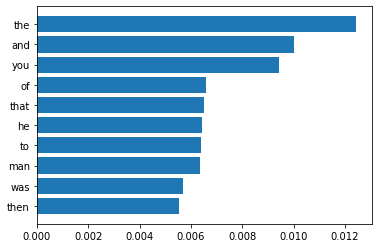

In [ ]:
plt.barh(feature_names[-10:], feature_importances[-10:])